In [1]:
import tweepy
import yaml
import pandas as pd
from pandas import json_normalize

In [2]:
with open('config.yml', "r") as stream:
    try:
        cf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


auth = tweepy.OAuth1UserHandler(
    cf['twitter_key'], 
    cf['twitter_secret'], 
    cf['twitter_access_key'], 
    cf['twitter_access_secret']
)

In [70]:
def get_tweets(res):
    # https://stackoverflow.com/questions/70371657/problem-with-getting-tweet-fields-from-twitter-api-2-0-using-tweepy
    # Inspired by https://stackoverflow.com/a/34065538/1391964
    fields = ['id', 'text'] + tweet_fields
    df = pd.DataFrame({fn: getattr(tweet, fn) for fn in fields} for tweet in res.data)
    df = pd.concat([df, json_normalize(df['public_metrics'])], axis=1).drop('public_metrics', axis=1)
    df = df.set_index('id')
    return df

def get_context(df):
    # Context Annotations
    df_context_annotations = df[df['context_annotations'].str.len() > 0].loc[:,['context_annotations']]
    df_context_annotations = df_context_annotations.explode('context_annotations')
    df_context_annotations = json_normalize(df_context_annotations['context_annotations'], sep="_").set_index(df_context_annotations.index)
    return(df_context_annotations)

def get_entities(df):
    # Entities
    df_entities = json_normalize(df['entities']).set_index(df.index)

    entity_dict = {}

    for entity in df_entities.columns:
        new_df = df_entities.explode(entity)
        new_df = json_normalize(new_df[entity]).set_index(new_df.index).dropna(how='all')
        new_df = new_df.add_prefix(entity + '_')
        entity_dict[entity] = new_df
    
    return entity_dict

In [118]:
client = tweepy.Client(bearer_token=cf['twitter_bearer'])

tweet_fields = ['author_id',
                'attachments',
                'conversation_id',
                'created_at',
                'geo',
                'in_reply_to_user_id',
                'lang',
                'referenced_tweets', # nested array
                'context_annotations', # nested
                'entities', # nested
                'public_metrics'] # json_normalize]

df = pd.DataFrame()

# @bennstancil
for tweets in tweepy.Paginator(client.get_users_tweets,
                               id=1643966166,
                               tweet_fields=tweet_fields,
                               max_results=100,
                               limit=20):
    df = pd.concat([df, get_tweets(tweets)], axis=0)
    #df_dict['context'] = get_context(df_dict['tweets'])
    #df_dict = df_dict.update(get_entities(df_dict['tweets']))

In [119]:
df_context = get_context(df)
dict_entities = get_entities(df)
df = df.drop(['context_annotations', 'entities'], axis=1)

In [120]:
df

,text,author_id,attachments,conversation_id,created_at,geo,in_reply_to_user_id,lang,referenced_tweets,retweet_count,reply_count,like_count,quote_count
id,,,,,,,,,,,,,
1505737553290293251,@ryanjanssen @g_xing definitely better than so...,1643966166,None,1504863910314315789,2022-03-21 02:46:22+00:00,None,1.308685e+08,en,"[(type, id)]",0,0,0,0
1505737042936078336,"@leoebfolsom with rails/django, you get a much...",1643966166,None,1502338198416072707,2022-03-21 02:44:20+00:00,None,1.643966e+09,en,"[(type, id)]",0,0,0,0
1505736731080884230,@leoebfolsom i doubt that; my guess is that it...,1643966166,None,1502338198416072707,2022-03-21 02:43:06+00:00,None,2.198416e+08,en,"[(type, id)]",0,1,0,0
1505736384732041216,"@leoebfolsom for sure, and thanks!",1643966166,None,1502338198416072707,2022-03-21 02:41:44+00:00,None,2.198416e+08,en,"[(type, id)]",0,0,0,0
1505641332232007680,@dada_dad_ Speaking as someone who's only work...,1643966166,None,1505428143363878912,2022-03-20 20:24:01+00:00,None,4.523085e+08,en,"[(type, id)]",0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374969773286621184,What happens if the US intervenes in Syria? 60...,1643966166,{'media_keys': ['3_374969773295009792']},374969773286621184,2013-09-03 18:58:55+00:00,None,NaN,en,None,0,0,0,0
373667865259290624,"@scottorn thanks, I'm glad you enjoyed it. I'l...",1643966166,None,373611107853672448,2013-08-31 04:45:36+00:00,None,8.545872e+06,en,"[(type, id)]",0,0,1,0
373240281916665856,RT @ttunguz: Great new data science blog on @s...,1643966166,None,373240281916665856,2013-08-30 00:26:32+00:00,None,NaN,en,"[(type, id)]",1,0,0,0


In [121]:
df_context

,domain_id,domain_name,domain_description,entity_id,entity_name,entity_description
id,,,,,,
1505217827921350659,10,Person,Named people in the world like Nelson Mandela,982336316460290049,Mark Zuckerberg,Mark Zuckerberg
1505029658085150723,65,Interests and Hobbies Vertical,"Top level interests and hobbies groupings, lik...",781974596148793345,Business & finance,NaN
1505029658085150723,66,Interests and Hobbies Category,"A grouping of interests and hobbies entities, ...",849075881653846016,Startups,Startups
1505027932779073537,45,Brand Vertical,Top level entities that describe a Brands indu...,781972125171060736,Auto,NaN
1505027932779073537,46,Brand Category,Categories within Brand Verticals that narrow ...,781972125179518977,Auto Manufacturer,NaN
...,...,...,...,...,...,...
584540733161504768,3,TV Shows,Television shows from around the world,10031306963,College Basketball,NaN
584540733161504768,3,TV Shows,Television shows from around the world,10035904483,2015 March Madness Tournament,NaN
584540733161504768,4,TV Episodes,Television show episodes,10036709480,Kentucky vs. Wisconsin,NaN


In [122]:
dict_entities['urls']

,urls_start,urls_end,urls_url,urls_expanded_url,urls_display_url,urls_images,urls_status,urls_title,urls_description,urls_unwound_url
id,,,,,,,,,,
1505641332232007680,263.0,286.0,https://t.co/CHuCs5XsWD,https://roundup.getdbt.com/p/the-perfect-north...,roundup.getdbt.com/p/the-perfect-…,NaN,NaN,NaN,NaN,NaN
1505639860786262016,244.0,267.0,https://t.co/Hmio7ggRqz,https://www.washingtonpost.com/local/traffican...,washingtonpost.com/local/traffica…,NaN,NaN,NaN,NaN,NaN
1505217827921350659,17.0,40.0,https://t.co/u6wkR0dNNM,https://twitter.com/benedictevans/status/39781...,twitter.com/benedictevans/…,NaN,NaN,NaN,NaN,NaN
1504904989151571970,235.0,258.0,https://t.co/2j3fmK1NGh,https://twitter.com/pedram_navid/status/150489...,twitter.com/pedram_navid/s…,NaN,NaN,NaN,NaN,NaN
1504864349206286376,42.0,65.0,https://t.co/vGra6fbHyW,https://docs.google.com/forms/d/e/1FAIpQLSeDj7...,docs.google.com/forms/d/e/1FAI…,[{'url': 'https://pbs.twimg.com/news_img/15048...,200.0,Are we good at business?,Turing a profit in Silicon Valley,https://docs.google.com/forms/d/e/1FAIpQLSeDj7...
...,...,...,...,...,...,...,...,...,...,...
374970328570527744,113.0,135.0,http://t.co/y6iAcR50wt,https://twitter.com/bennstancil/status/3749703...,pic.twitter.com/y6iAcR50wt,NaN,NaN,NaN,NaN,NaN
374969773286621184,94.0,116.0,http://t.co/2bcM4ANRv1,http://bennstancil.com/will-syria-be-different,bennstancil.com/will-syria-be-…,NaN,NaN,NaN,NaN,NaN
374969773286621184,117.0,139.0,http://t.co/6SW7697Ll8,https://twitter.com/bennstancil/status/3749697...,pic.twitter.com/6SW7697Ll8,NaN,NaN,NaN,NaN,NaN


In [123]:
dict_entities['mentions']

,mentions_start,mentions_end,mentions_username,mentions_id
id,,,,
1505737553290293251,0.0,12.0,ryanjanssen,130868475
1505737553290293251,13.0,20.0,g_xing,521285413
1505737042936078336,0.0,12.0,leoebfolsom,219841618
1505736731080884230,0.0,12.0,leoebfolsom,219841618
1505736384732041216,0.0,12.0,leoebfolsom,219841618
...,...,...,...,...
373240214006673408,0.0,9.0,arjunblj,25552514
372826655690985472,1.0,17.0,FiveThirtyEight,2303751216
372826655690985472,28.0,36.0,nytimes,807095


In [124]:
dict_entities['annotations']

,annotations_start,annotations_end,annotations_probability,annotations_type,annotations_normalized_text
id,,,,,
1505029658085150723,33.0,46.0,0.5102,Organization,Silicon Valley
1505027932779073537,17.0,21.0,0.7667,Organization,Tesla
1502345129260195846,157.0,166.0,0.7645,Organization,Salesforce
1501773933321891840,63.0,69.0,0.4578,Product,twitter
1501773933321891840,139.0,143.0,0.7163,Person,steve
...,...,...,...,...,...
377134447952285696,36.0,49.0,0.5852,Person,Yusmeiro Petit
376042773201182720,26.0,34.0,0.2923,Product,Hyperloop
376041812428738560,28.0,36.0,0.3334,Organization,Hyperloop


In [125]:
dict_entities['hashtags']

,hashtags_start,hashtags_end,hashtags_tag
id,,,
1502341825528541194,12.0,25.0,deletewordle
1476725385819738113,64.0,71.0,HACKER
1467976965072195585,107.0,112.0,data
1085595978944503808,108.0,120.0,coffreecake
1067934400673865729,16.0,31.0,CarlsenCaruana
1067934400673865729,74.0,97.0,worldchesschampionship
746021853848711169,29.0,38.0,custserv
746021853848711169,51.0,58.0,Python
578259856886484992,93.0,103.0,analytics


df

In [126]:
df

,text,author_id,attachments,conversation_id,created_at,geo,in_reply_to_user_id,lang,referenced_tweets,retweet_count,reply_count,like_count,quote_count
id,,,,,,,,,,,,,
1505737553290293251,@ryanjanssen @g_xing definitely better than so...,1643966166,None,1504863910314315789,2022-03-21 02:46:22+00:00,None,1.308685e+08,en,"[(type, id)]",0,0,0,0
1505737042936078336,"@leoebfolsom with rails/django, you get a much...",1643966166,None,1502338198416072707,2022-03-21 02:44:20+00:00,None,1.643966e+09,en,"[(type, id)]",0,0,0,0
1505736731080884230,@leoebfolsom i doubt that; my guess is that it...,1643966166,None,1502338198416072707,2022-03-21 02:43:06+00:00,None,2.198416e+08,en,"[(type, id)]",0,1,0,0
1505736384732041216,"@leoebfolsom for sure, and thanks!",1643966166,None,1502338198416072707,2022-03-21 02:41:44+00:00,None,2.198416e+08,en,"[(type, id)]",0,0,0,0
1505641332232007680,@dada_dad_ Speaking as someone who's only work...,1643966166,None,1505428143363878912,2022-03-20 20:24:01+00:00,None,4.523085e+08,en,"[(type, id)]",0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374969773286621184,What happens if the US intervenes in Syria? 60...,1643966166,{'media_keys': ['3_374969773295009792']},374969773286621184,2013-09-03 18:58:55+00:00,None,NaN,en,None,0,0,0,0
373667865259290624,"@scottorn thanks, I'm glad you enjoyed it. I'l...",1643966166,None,373611107853672448,2013-08-31 04:45:36+00:00,None,8.545872e+06,en,"[(type, id)]",0,0,1,0
373240281916665856,RT @ttunguz: Great new data science blog on @s...,1643966166,None,373240281916665856,2013-08-30 00:26:32+00:00,None,NaN,en,"[(type, id)]",1,0,0,0


## How many tweets are 'status post' and how many are 'replies'?

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [132]:
df['is_reply'] = np.where(df['in_reply_to_user_id'].isnull(), 0, 1)

In [135]:
df['is_reply'].value_counts(normalize=True)

1    0.777105
0    0.222895
Name: is_reply, dtype: float64

<AxesSubplot:xlabel='is_reply', ylabel='count'>

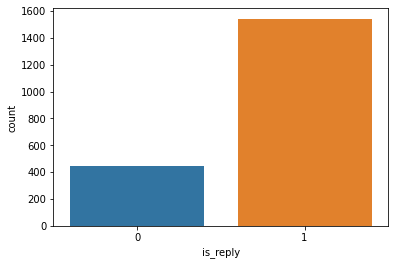

In [136]:
sns.countplot(x='is_reply', data=df)

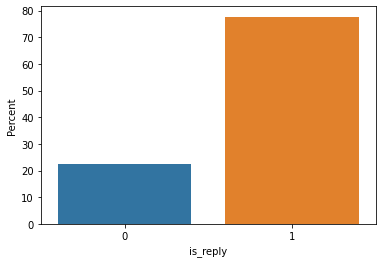

In [144]:
# y can be anything since we're not using the value
ax = sns.barplot(x='is_reply', y='is_reply', data=df, estimator=lambda is_reply: len(is_reply)/len(df) * 100)
ax.set(ylabel="Percent")
plt.show()

Looks like this user replies 78% of the time!

## Top Domains and Entities

In [147]:
df_context['domain_name'].value_counts(normalize=True)[0:10]

Interests and Hobbies Vertical    0.156198
Brand                             0.107438
Entities [Entity Service]         0.104132
Interests and Hobbies Category    0.100826
Brand Category                    0.095041
Person                            0.075207
Interests and Hobbies             0.055372
Brand Vertical                    0.054545
TV Shows                          0.029752
Product                           0.028926
Name: domain_name, dtype: float64

In [148]:
df_context['entity_name'].value_counts(normalize=True)[0:10]

Services              0.057851
Technology            0.042975
Food                  0.039669
Generic Food          0.031405
Business & finance    0.030579
Cake decorations      0.028099
Drinks                0.023140
Generic Drinks        0.020661
B2B                   0.019008
Coffee                0.016529
Name: entity_name, dtype: float64

In [151]:
dict_entities['annotations']['annotations_normalized_text'].value_counts(normalize=True)[0:10]

Kim Novak         0.025408
NBA               0.016334
twitter           0.014519
ESPN              0.012704
US                0.012704
Silicon Valley    0.012704
Trump             0.010889
NYC               0.009074
Twitter           0.009074
Netflix           0.009074
Name: annotations_normalized_text, dtype: float64

In [152]:
dict_entities['hashtags']['hashtags_tag'].value_counts(normalize=True)[0:10]

Oscars              0.093023
Oscars2014          0.093023
dataviz             0.046512
WorldCup            0.046512
SOTU                0.023256
Frozen              0.023256
SuperBowI           0.023256
SuperSmack          0.023256
DiGiorNOYOUDIDNT    0.023256
deletewordle        0.023256
Name: hashtags_tag, dtype: float64

In [175]:
import spacy

nlp = spacy.load("en_core_web_sm")

# https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Read-in-New-York-Times-Dataset
def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc]
    return lemma_list
    

df['preproc'] = df['text'].apply(lemmatize)

In [176]:
df['preproc']

id
1505737553290293251    [@ryanjanssen, @g_xing, definitely, well, than...
1505737042936078336    [@leoebfolsom, with, rail, /, django, ,, you, ...
1505736731080884230    [@leoebfolsom, I, doubt, that, ;, my, guess, b...
1505736384732041216          [@leoebfolsom, for, sure, ,, and, thank, !]
1505641332232007680    [@dada_dad, _, speak, as, someone, who, be, on...
                                             ...                        
374969773286621184     [what, happen, if, the, US, intervene, in, Syr...
373667865259290624     [@scottorn, thank, ,, I, be, glad, you, enjoy,...
373240281916665856     [RT, @ttunguz, :, great, new, data, science, b...
373240214006673408     [@arjunblj, thank, !, glad, you, enjoy, it, ,,...
372826655690985472     [.@fivethirtyeight, work, at, @nytimes, and, @...
Name: preproc, Length: 1983, dtype: object